In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal.windows as windows
import re
import os

from scipy.fft import fft, fftshift, ifft, ifftshift, fftfreq

matplotlib.style.use('bmh')

In [6]:
dir = "/home/mhetu/Desktop/gpr/data/antenna_tests8/"

rx_buffer1_files = [
    "ch1_400_1000_0cm.npy",
    "ch1_400_1000_18cm.npy",
    "ch1_400_1000_30cm.npy",
    "ch1_400_1000_48cm.npy",
    "ch1_400_1000_265cm.npy",
    "ch1_400_1000_295cm.npy",
    "ch1_400_1000_313cm.npy",

]

rx_buffer2_files = [
    "ch2_400_1000_0cm.npy",
    "ch2_400_1000_18cm.npy",
    "ch2_400_1000_30cm.npy",
    "ch2_400_1000_48cm.npy",
    "ch2_400_1000_265cm.npy",
    "ch2_400_1000_295cm.npy",
    "ch2_400_1000_313cm.npy",

]

dir = "/home/mhetu/Desktop/gpr/data/loopback_tests/"


/tmp/ipykernel_48678/4106120855.py:66: RuntimeWarning: divide by zero encountered in log10
  mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)


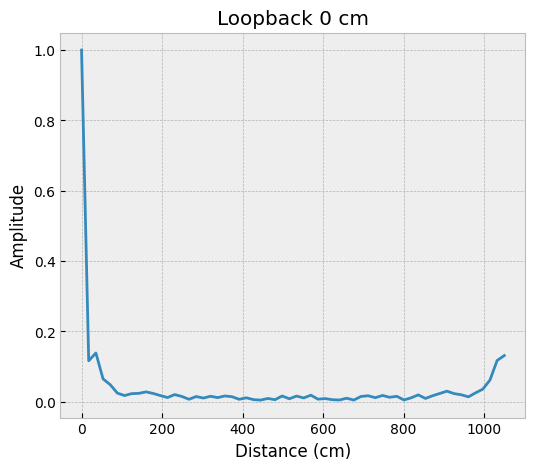

In [44]:
delR = 3e8*0.7/(2*600e6)
maxR = 3e8*0.7/(2*10e6)

x_arr = np.linspace(0, maxR, num=int(maxR/delR))*100

rx_buffer1 = np.load(dir+"ch2_400_1000_0cm.npy")
rx_buffer2 = np.load(dir+"ch1_400_1000_0cm.npy")
cms = 0

fs = 20e6 #Sample frequency
LOs = np.unique(rx_buffer1[:,1]) #The LO values encoded in the output
nsp = len(LOs) #The number of LO values taken
Np = min(rx_buffer1[rx_buffer1[:, 1] == LOs[i], 0].shape[0] for i in range(nsp)) #Length of a pulse
N = len(rx_buffer1) #Length of the full buffer
N2 = int(N/2) 

W = windows.tukey(Np)
Tp = 40001/fs #period for upsampling
L = (fs)*Tp #Upsampling factor
Lup = 2*L
n_zeros = int(Lup/2)

stacklen = N #Taken from the thesis

#allocate an upsampled stack
dft_stack = np.zeros(stacklen, dtype = np.complex128)

for i in range(nsp):

    # Initializing reference waveform
    ref_chirp = rx_buffer1[rx_buffer1[:,1]==LOs[i], 0][0:N]
    rx_chirp = rx_buffer2[rx_buffer2[:,1]==LOs[i], 0][0:N]
    #plt.plot(fft(ref_chirp))
    #fx = fft(ref_chirp)
    #fx[Np//2: Np] = 0
    #fx[0:Np//2] = fx[0:Np//2]/2
    #plt.plot(fx)
    #plt.plot(fft(np.real(ref_chirp)))
    #plt.show()
    #Take FFTs and use window
    ref_dft = fft(ref_chirp)
    rx_dft = fft(rx_chirp)


    
    #Compute matched filter
    
    mf_dft = ref_dft * np.conjugate(rx_dft)
    mf_dft = mf_dft*W

    
    #Upsample
    zeros_start = np.zeros(n_zeros) #Upsample by shifting
    zeros_end = np.zeros(stacklen-n_zeros-Np)
    dft_shifted_padded = np.concatenate([zeros_start, mf_dft, zeros_end])

    
    mf_dft_shift = np.roll(dft_shifted_padded, int(i * Np)) #Shift forward to fill the space
    mf_dft_shift = fftshift(mf_dft_shift)
    freqs = fftshift(fftfreq(stacklen, 1/fs))
    
    dft_stack += mf_dft_shift
#print(dft_stack)


mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)

sww = ifftshift(ifft(dft_stack)) #Ifft

p = 20*np.log10(np.abs(sww))

y_arr = np.abs(sww)[int(len(sww)/2):int(len(sww)/2+int(maxR/delR))]
y_arr /= y_arr.max()

fig, ax = plt.subplots(figsize = (6,5))

ax.plot(x_arr, y_arr)
#ax.plot([cms, cms],[0,1], linestyle = '--', alpha=0.75)

ax.set_title(f"Loopback {cms} cm")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Distance (cm)")
#sample_range = (2.645725e6, 2.645825e6)
#sample_range = (len(sww)/2+28, len(sww)/2 + 100)
#ax.set_xlim(0, 1500)
fig.savefig(f'Loopback_{cms}cm_dist.png', dpi=300)
plt.show()

In [38]:
delR = 3e8*0.7/(2*600e6)
maxR = 3e8*0.7/(2*10e6)
print(maxR)

x_arr = np.linspace(0, maxR, num=int(maxR/delR))*100
print(x_arr)

10.5
[   0.           17.79661017   35.59322034   53.38983051   71.18644068
   88.98305085  106.77966102  124.57627119  142.37288136  160.16949153
  177.96610169  195.76271186  213.55932203  231.3559322   249.15254237
  266.94915254  284.74576271  302.54237288  320.33898305  338.13559322
  355.93220339  373.72881356  391.52542373  409.3220339   427.11864407
  444.91525424  462.71186441  480.50847458  498.30508475  516.10169492
  533.89830508  551.69491525  569.49152542  587.28813559  605.08474576
  622.88135593  640.6779661   658.47457627  676.27118644  694.06779661
  711.86440678  729.66101695  747.45762712  765.25423729  783.05084746
  800.84745763  818.6440678   836.44067797  854.23728814  872.03389831
  889.83050847  907.62711864  925.42372881  943.22033898  961.01694915
  978.81355932  996.61016949 1014.40677966 1032.20338983 1050.        ]


/tmp/ipykernel_48678/742558260.py:67: RuntimeWarning: divide by zero encountered in log10
  mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)


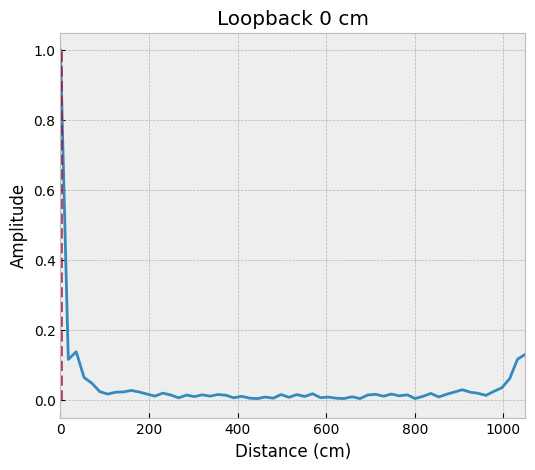

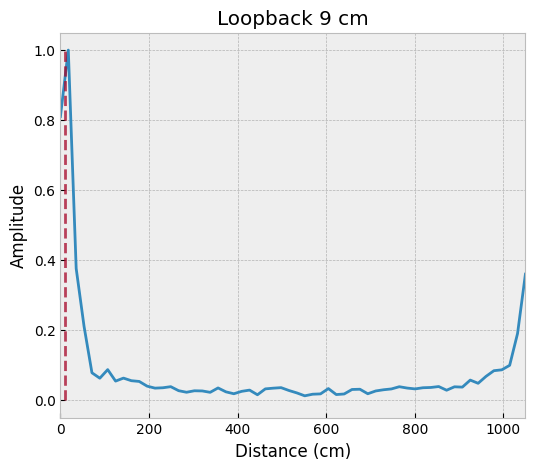

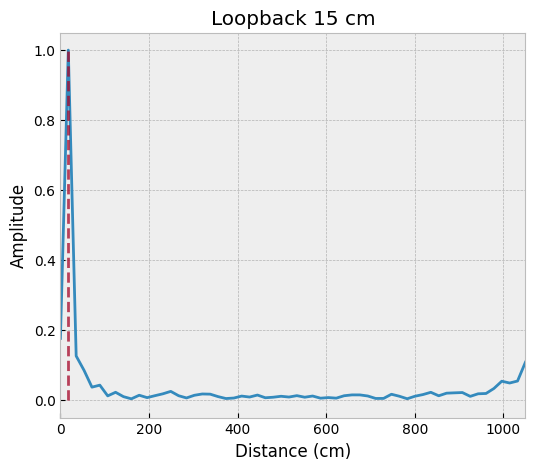

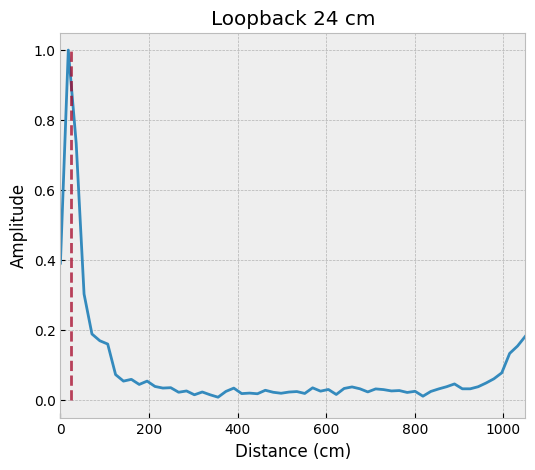

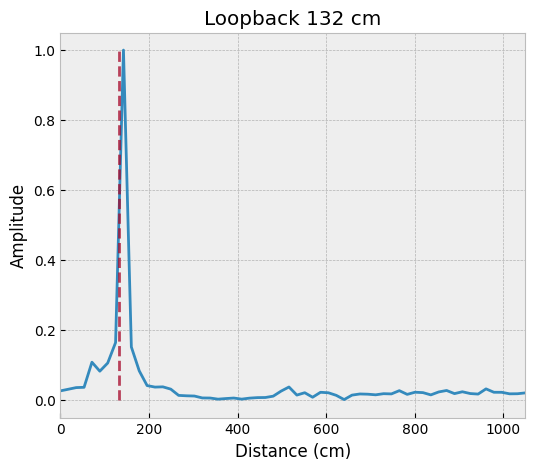

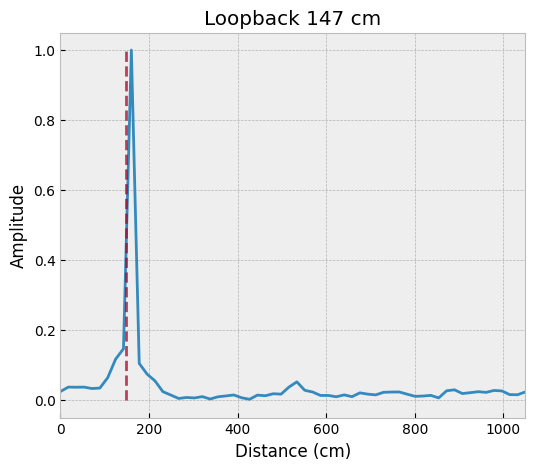

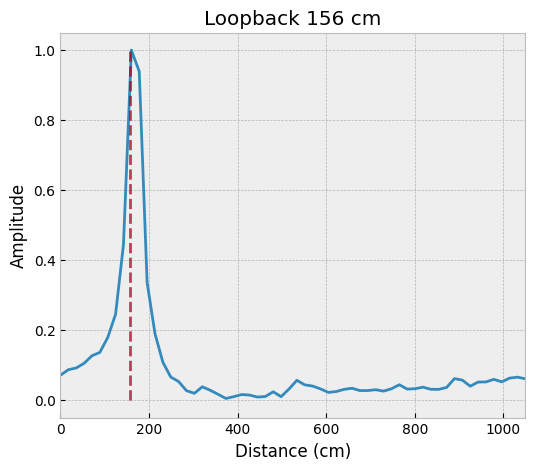

In [46]:
delR = 3e8*0.7/(2*600e6)
maxR = 3e8*0.7/(2*10e6)

x_arr = np.linspace(0, maxR, num=int(maxR/delR))*100

for file1, file2 in zip(rx_buffer1_files, rx_buffer2_files):
    rx_buffer1 = np.load(dir+file2)
    rx_buffer2 = np.load(dir+file1)
    cms = re.search(r'(\d+)cm', file1).group(1)
    
    fs = 20e6 #Sample frequency
    LOs = np.unique(rx_buffer1[:,1]) #The LO values encoded in the output
    nsp = len(LOs) #The number of LO values taken
    Np = min(rx_buffer1[rx_buffer1[:, 1] == LOs[i], 0].shape[0] for i in range(nsp)) #Length of a pulse
    N = len(rx_buffer1) #Length of the full buffer
    N2 = int(N/2) 

    W = windows.tukey(Np)
    Tp = 40001/fs #period for upsampling
    L = (fs)*Tp #Upsampling factor
    Lup = 2*L
    n_zeros = int(Lup/2)
    
    stacklen = N #Taken from the thesis

    #allocate an upsampled stack
    dft_stack = np.zeros(stacklen, dtype = np.complex128)
    
    for i in range(nsp):
    
        # Initializing reference waveform
        ref_chirp = rx_buffer1[rx_buffer1[:,1]==LOs[i], 0][0:N]
        rx_chirp = rx_buffer2[rx_buffer2[:,1]==LOs[i], 0][0:N]
        #plt.plot(fft(ref_chirp))
        #fx = fft(ref_chirp)
        #fx[Np//2: Np] = 0
        #fx[0:Np//2] = fx[0:Np//2]/2
        #plt.plot(fx)
        #plt.plot(fft(np.real(ref_chirp)))
        #plt.show()
        #Take FFTs and use window
        ref_dft = fft(ref_chirp)
        rx_dft = fft(rx_chirp)
    
    
        
        #Compute matched filter
        
        mf_dft = ref_dft * np.conjugate(rx_dft)
        mf_dft = mf_dft*W

        
        #Upsample
        zeros_start = np.zeros(n_zeros) #Upsample by shifting
        zeros_end = np.zeros(stacklen-n_zeros-Np)
        dft_shifted_padded = np.concatenate([zeros_start, mf_dft, zeros_end])

        
        mf_dft_shift = np.roll(dft_shifted_padded, int(i * Np)) #Shift forward to fill the space
        mf_dft_shift = fftshift(mf_dft_shift)
        freqs = fftshift(fftfreq(stacklen, 1/fs))
        
        dft_stack += mf_dft_shift
    #print(dft_stack)


    mag_stack = 20*np.log10(np.abs(dft_stack/np.max(dft_stack))**2)

    sww = ifftshift(ifft(dft_stack)) #Ifft
    
    p = 20*np.log10(np.abs(sww))
    
    y_arr = np.abs(sww)[int(len(sww)/2):int(len(sww)/2+int(maxR/delR))]
    y_arr /= y_arr.max()

    fig, ax = plt.subplots(figsize = (6,5))

    ax.plot(x_arr, y_arr)
    ax.plot([int(int(cms)/2)+1, int(int(cms)/2)+1],[0,1], linestyle = '--', alpha=0.75)
    
    ax.set_title(f"Loopback {str(int(int(cms)/2))} cm")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Distance (cm)")
    #sample_range = (2.645725e6, 2.645825e6)
    #sample_range = (len(sww)/2+28, len(sww)/2 + 100)
    ax.set_xlim(0, maxR*100)
    fig.savefig(f'Loopback_{str(int(int(cms)/2))}cm.png', dpi=300)
    plt.show()
    